In [55]:
# Импорт библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

import time
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from joblib import Parallel, delayed

import cornac
import surprise
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

In [56]:
# Функции для метрик
def calculate_rmse(df):
    return np.sqrt(mean_squared_error(df.dropna()['rating'], df.dropna()['predicted_rating']))

def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual: #and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k) if len(actual) > 0 else 0.0

def calculate_mapk(df, k=10):
    user_group = df.groupby('userId')
    apk_scores = []
    for user, group in user_group:
        actual = group.dropna()['movieId'].values
        if len(actual) == 0:
            continue
        predicted = group.sort_values(by='predicted_rating', ascending=False)['movieId'].values
        apk_scores.append(apk(actual, predicted, k))
    return np.mean(apk_scores)

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k] # to float
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.0

def ndcg_at_k(actual, predicted, k=10):
    predicted = predicted[:k]
    ideal = sorted(actual, reverse=True)[:k]
    return dcg_at_k(predicted, k) / dcg_at_k(ideal, k)

def calculate_ndcgk(df, k=10):
    user_group = df.dropna().groupby('userId') # разделить пользователей
    ndcg_scores = []
    for user, group in user_group:
        actual = group['rating'].values # реальный рейтинг
        predicted = group.sort_values(by='predicted_rating', ascending=False)['rating'].values # рейтинг, как решила модель
        ndcg_scores.append(ndcg_at_k(actual, predicted, k))
    return np.mean(ndcg_scores)

# def calculate_novelty(df, item_popularity, k=10):
#     user_group = df.groupby('userId')
#     novelty_scores = []
#     for user, group in tqdm(user_group):
#         recommended_items = group.sort_values(by='predicted_rating', ascending=False)['movieId'].values[:k]
#         novelty = np.mean([np.log2(len(df['userId'].unique()) / item_popularity[item]) for item in recommended_items if item in item_popularity and item_popularity[item] != 0])
#         if not np.isnan(novelty):
#             novelty_scores.append(novelty)
#     print(rf'$log_2$ max: {np.log2(len(df["userId"].unique())):.3}')
#     return np.mean(novelty_scores) if novelty_scores else 0


def calculate_novelty(df, item_popularity, k=10):
    num_users = len(df['userId'].unique())

    # Предварительно вычисляем логарифмы для всех элементов
    log_popularity = {item: np.log2(num_users / pop) for item, pop in item_popularity.items() if pop != 0}
    
    # Функция для расчета новизны для одного пользователя
    def user_novelty(group):
        recommended_items = group.nlargest(k, 'predicted_rating')['movieId'].values
        novelty = [log_popularity[item] for item in recommended_items if item in log_popularity]
        return np.mean(novelty) if novelty else np.nan
    
    # Применяем к каждой группе
    novelty_scores = df.groupby('userId').apply(user_novelty).dropna()

    print(rf'$log_2$ max: {np.log2(num_users):.3}')
    return novelty_scores.mean() if not novelty_scores.empty else 0

def calculate_diversity(df, item_similarity_matrix, k=10, matrix_columns=None):
    user_group = df.groupby('userId')
    diversity_scores = []
    
    for user, group in user_group:
        recommended_items = group.sort_values(by='predicted_rating', ascending=False)['movieId'].values[:k]
        total_pairs = 0
        diversity = 0
        for i in range(len(recommended_items)):
            for j in range(i + 1, len(recommended_items)):
                # Получаем индексы фильмов в матрице
                if recommended_items[i] in matrix_columns and recommended_items[j] in matrix_columns:
                    idx_i = matrix_columns.get_loc(recommended_items[i])
                    idx_j = matrix_columns.get_loc(recommended_items[j])
                    total_pairs += 1
                    diversity += (1 - item_similarity_matrix[idx_i, idx_j])
        
        if total_pairs > 0:
            diversity_scores.append(diversity / total_pairs)
    
    return np.mean(diversity_scores) if diversity_scores else 0


In [57]:
def create_cf_matrix(train, cf_type='user'):

    """
    Создает матрицу для коллаборативной фильтрации.
    
    Параметры:
    - train: DataFrame с обучающими данными.
    - cf_type: 'user' для пользователь-фильм матрицы или 'item' для фильм-пользователь матрицы.
    
    Возвращает:
    - Матрица для коллаборативной фильтрации.
    """
    if cf_type == 'user':
        # Матрица пользователь-фильм
        return train.pivot(index='userId', columns='movieId', values='rating')
    elif cf_type == 'item':
        # Матрица фильм-пользователь
        return train.pivot(index='movieId', columns='userId', values='rating')
    else:
        raise ValueError("cf_type должен быть 'user' или 'item'")

In [58]:
def load_and_split_data(file_path, test_size=0.3, random_state=42):
    df = pd.read_csv(file_path)
    train, test = train_test_split(df, test_size=test_size, random_state=random_state)
    return train, test, df

In [59]:
# Загрузка данных
df = pd.read_csv('data/ml-latest-small/ratings.csv')
n_users = df['userId'].nunique()
n_items = df['movieId'].nunique()

# Создание индексов для пользователей и фильмов
user_ids = df['userId'].astype('category').cat.codes.values
item_ids = df['movieId'].astype('category').cat.codes.values

df['user_idx'] = user_ids
df['item_idx'] = item_ids

# Разделение данных на тренировочные и тестовые наборы
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Матрица рейтингов
def create_matrix(df, n_users, n_items):
    matrix = np.zeros((n_users, n_items))
    matrix[:] = np.nan
    for row in df.itertuples():
        matrix[row.user_idx, row.item_idx] = row.rating
    return matrix

R_train = create_matrix(train_df, n_users, n_items)
R_test = create_matrix(test_df, n_users, n_items)

In [60]:
def counting_metrics(train, test, results, names):
    test_df_flatten = pd.DataFrame(test).stack(dropna=False).reset_index()
    test_df_flatten.columns = ['userId', 'movieId', 'rating']

    # Подготовка для сбора всех результатов
    all_results = []

    for result, name in zip(results, names):  # Пройдем по результатам и именам методов одновременно
        pred_df_flatten = result.stack().reset_index()
        pred_df_flatten.columns = ['userId', 'movieId', 'predicted_rating']

        merged_df = pd.merge(test_df_flatten, pred_df_flatten, on=['userId', 'movieId'])

        # Расчет RMSE
        rmse = calculate_rmse(merged_df)

        # Определяем значения K для MAP и NDCG
        k_values = [1, 5, 10, 20]

        # Считаем MAP@K для каждого значения K
        mapk_results = {f'MAP@{k}': calculate_mapk(merged_df, k=k) for k in k_values}

        # Считаем NDCG@K для каждого значения K
        ndcgk_results = {f'NDCG@{k}': calculate_ndcgk(merged_df, k=k) for k in k_values}

        # Рассчитываем Novelty и Diversity
        item_popularity = pd.DataFrame(train).count().to_dict()
        item_similarity_matrix = 1 - pairwise_distances(pd.DataFrame(train).T.fillna(0), metric='cosine')

        novelty = calculate_novelty(merged_df, item_popularity, k=10)
        diversity = calculate_diversity(merged_df, item_similarity_matrix, k=10, matrix_columns=pd.DataFrame(train).columns)

        # Собираем метрики для текущего result
        result_metrics = {
            'Method': name,  # Добавляем название метода
            'RMSE': rmse,
            'Novelty': novelty,
            'Diversity': diversity,
            **mapk_results,  # Добавляем результаты MAP@K
            **ndcgk_results  # Добавляем результаты NDCG@K
        }

        # Добавляем в общий список результатов
        all_results.append(result_metrics)

    # Преобразуем результаты в DataFrame
    return pd.DataFrame(all_results)

#### Основная часть

In [61]:
def collaborative_filtering(train, test, cf_type='user', use_z_score=True, N=50):
    matrix = pd.DataFrame(train)
    matrix_test = pd.DataFrame(test)
    similarity = cosine_similarity(matrix.fillna(0))
    means = matrix.mean(axis=1) # [610, mean]
    stds = matrix.fillna(0).std(axis=1) if use_z_score else None

    if use_z_score:
        matrix_normalized = matrix.sub(means, axis=0).div(stds, axis=0).fillna(0)

    # Предварительно вычисляем топ-N для всех пользователей
    top_similarities = np.argsort(-similarity, axis=1)[:, :N]


    # Массив для предсказанных рейтингов
    predicted_ratings = np.zeros(matrix_test.shape)


    for user_index in range(matrix_test.shape[0]):
        # Получаем топ-N похожих пользователей
        top_similar = top_similarities[user_index]

        similarities = similarity[user_index, top_similar]

        # Все рейтинги топ-N пользователей
        if use_z_score:
            relevant_ratings = matrix_normalized.iloc[top_similar]
        else:
            relevant_ratings = matrix.iloc[top_similar] # (610, 9724) -> (top_similar, 9724)

        # Маска для фильмов, которые были оценены похожими пользователями
        mask = relevant_ratings > 0

        # Векторная операция для предсказания всех рейтингов для данного пользователя
        numerator = np.dot(similarities, (relevant_ratings.fillna(0).values - means.iloc[top_similar].values.reshape(-1, 1)) * mask.values)
        denominator = np.sum(np.abs(similarities[:, np.newaxis]) * mask.values, axis=0)

        # Предсказанные значения
        predicted_ratings[user_index, :] = means.iloc[user_index] + (numerator / (denominator + 1e-9))  # Добавляем малое число для избежания деления на 0

        if use_z_score:
            predicted_ratings[user_index, :] = means.iloc[user_index] + predicted_ratings[user_index, :] * stds.iloc[user_index]

    # Создаем DataFrame для предсказанных рейтингов
    predicted_matrix = pd.DataFrame(predicted_ratings, index=matrix.index, columns=matrix.columns)
    return predicted_matrix

In [62]:
def cluster_based_cf(train, test, n_clusters=40, use_z_score=False, cf_type='user'):
    """
    Кластерная коллаборативная фильтрация с векторизованными операциями.
    
    Параметры:
    - train: DataFrame с обучающими данными.
    - test: DataFrame M*N с тестовыми данными (где M - пользователи, N - фильмы).
    - n_clusters: количество кластеров для K-means.
    - use_z_score: флаг для использования Z-score нормализации.
    - cf_type: 'user' для пользователь-фильм матрицы или 'item' для фильм-пользователь матрицы.
    """
    # Преобразуем train и test в DataFrame
    matrix = pd.DataFrame(train)
    test = pd.DataFrame(test)
    pred = test.copy()

    if use_z_score:
        # Нормализуем оценки с помощью z-score
        means = matrix.mean(axis=1)  # Среднее по пользователям (или фильмам)
        stds = matrix.fillna(0).std(axis=1)  # Стандартное отклонение по пользователям (или фильмам)
        matrix_normalized = matrix.sub(means, axis=0).div(stds, axis=0)
        matrix_for_clustering = matrix_normalized.fillna(0)
    else:
        # Используем обычную матрицу для кластеризации
        matrix_for_clustering = matrix.fillna(0)
    
    # Применяем K-means кластеризацию
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(matrix_for_clustering)
    
    # Создаем DataFrame для кластеров
    cluster_df = pd.DataFrame({'userId': matrix.index, 'cluster': clusters})
    
    if use_z_score:
        # Рассчитываем средние рейтинги для каждого кластера в нормализованной матрице
        cluster_means = matrix_normalized.groupby(clusters).mean()
        
        # Получаем предсказанные рейтинги для всех пользователей и фильмов
        user_clusters = cluster_df['cluster'].values  # Кластеры для каждого пользователя
        predicted_z_scores = cluster_means.loc[user_clusters].values  # Предсказания для всех пользователей
        
        # Преобразуем предсказания обратно в исходные единицы
        user_means = means.values[:, np.newaxis]  # Преобразуем вектора средних значений
        user_stds = stds.values[:, np.newaxis]  # Преобразуем вектора стандартных отклонений
        predicted_ratings = user_means + predicted_z_scores * user_stds  # Восстанавливаем рейтинги
        
        # Присваиваем предсказанные рейтинги обратно в матрицу test
        pred[:] = predicted_ratings
    else:
        # Рассчитываем средние рейтинги для каждого кластера
        cluster_means = matrix.groupby(clusters).mean()
        
        # Получаем предсказанные рейтинги для всех пользователей и фильмов
        user_clusters = cluster_df['cluster'].values
        predicted_ratings = cluster_means.loc[user_clusters].values
        
        # Присваиваем предсказанные рейтинги обратно в матрицу test
        pred[:] = predicted_ratings

    return pred

In [63]:
def voting_based_cf(train, test, cf_type='user', n_neighbors=40, use_knn=False):
    """
    Коллаборативная фильтрация с голосованием на основе сходства и KNN.

    Параметры:
    - train: DataFrame с обучающими данными (M пользователей * N фильмов).
    - test: DataFrame (M пользователей * N фильмов), где необходимо предсказать рейтинги.
    - cf_type: 'user' для пользователь-фильм матрицы или 'item' для фильм-пользователь матрицы.
    - n_neighbors: количество соседей для KNN или топ-N для голосования.
    - use_knn: флаг для использования KNN вместо простого выбора топ-N похожих пользователей/фильмов.

    Возвращает:
    - test: DataFrame с предсказанными значениями для матрицы теста.
    """
    matrix = pd.DataFrame(train)
    test = pd.DataFrame(test)
    pred = test.copy()

    # Транспонирование матрицы для item-based подхода
    if cf_type == 'item':
        matrix = matrix.T

    matrix_for_knn = matrix.fillna(0)
    
    # Если используем KNN
    if use_knn:
        knn = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine').fit(matrix_for_knn)
        distances, neighbors = knn.kneighbors(matrix_for_knn)
    else:
        # Вычисляем косинусное сходство
        similarity = cosine_similarity(matrix_for_knn)
        # Получаем индексы топ-N похожих пользователей/фильмов
        neighbors = np.argsort(similarity, axis=1)[:, -n_neighbors-1:-1]

    def predict_ratings(matrix, neighbors):
        """
        Векторизованное предсказание рейтингов.
        """
        num_users, num_items = matrix.shape
        predicted_ratings = np.zeros((num_users, num_items))
        
        # Проходим по каждому пользователю
        for user_index in tqdm(range(num_users)):
            neighbor_indices = neighbors[user_index]
            for item_index in range(num_items):
                neighbor_ratings = matrix.values[neighbor_indices, item_index]
                valid_ratings = neighbor_ratings[neighbor_ratings > 0]
                
                if len(valid_ratings) > 0:
                    predicted_ratings[user_index, item_index] = valid_ratings.mean()
                else:
                    predicted_ratings[user_index, item_index] = matrix.values[user_index].mean()
        
        return predicted_ratings
    
    predicted_ratings = predict_ratings(matrix, neighbors)

    pred[:] = predicted_ratings

    return pred

In [64]:
class SVD:
    def __init__(self, R, K=20, alpha=0.002, beta=0.02, iterations=100):
        self.R = np.nan_to_num(R)  # Заменяем NaN на 0
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.rmse_values = []
        self.map_values = []

    def train(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.nanmean(self.R)  # Учитываем только ненулевые значения

        # Сбор выборки, исключая NaN
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users) for j in range(self.num_items)
            if not np.isnan(self.R[i, j]) and self.R[i, j] > 0
        ]

        progress_bar = tqdm(total=self.iterations, desc="Training SVD")
        for iteration in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            progress_bar.set_postfix({'Iteration': iteration+1})
            progress_bar.update(1)
        progress_bar.close()

    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.predict(i, j)
            error = r - prediction

            # Обновление биасов
            self.b_u[i] += self.alpha * (error - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (error - self.beta * self.b_i[j])

            # Обновление скрытых факторов
            self.P[i, :] += self.alpha * (error * self.Q[j, :] - self.beta * self.P[i, :])
            self.Q[j, :] += self.alpha * (error * self.P[i, :] - self.beta * self.Q[j, :])

    def predict(self, i, j):
        return self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
    
    def predict_all(self):
        predictions = np.zeros((self.num_users, self.num_items))
        # progress_bar = tqdm(total=self.num_users * self.num_items, desc="Predicting")
        for i in range(self.num_users):
            for j in range(self.num_items):
                predictions[i, j] = self.predict(i, j)
        #         progress_bar.update(1)  # Обновляем прогресс после каждого j
        # progress_bar.close()
        return predictions

    def rmse(self):
        xs, ys = np.where(~np.isnan(self.R))  # Исключаем NaN значения
        predicted = []
        actual = []
        for x, y in zip(xs, ys):
            predicted.append(self.predict(x, y))
            actual.append(self.R[x, y])
        return np.sqrt(np.mean((np.array(predicted) - np.array(actual)) ** 2))


##### Ручная реализация

In [65]:
result_user_cf = collaborative_filtering(R_train, R_test, cf_type='user', use_z_score=False, N=10)
result_item_cf = collaborative_filtering(R_train.T, R_test.T, cf_type='item', use_z_score=False, N=10)
result_cluster_based_cf = cluster_based_cf(R_train, R_test, n_clusters=30, use_z_score=False, cf_type='user')
result_cluster_based_cf_z = cluster_based_cf(R_train, R_test, n_clusters=30, use_z_score=True, cf_type='user')
result_voting_based_cf = voting_based_cf(R_train, R_test, cf_type='user', n_neighbors=200, use_knn=False)

K = 50
iterations = 10
alpha = 0.02
beta = 0.02

svd = SVD(R_train, K=K, iterations=iterations, alpha=alpha, beta=beta)
svd.train()
results_MF = svd.predict_all()

metrics = counting_metrics(R_train, R_test, [result_user_cf, result_cluster_based_cf, result_cluster_based_cf_z, result_voting_based_cf], ['user', 'cluster', 'cluster_z','SVD'])
metrics2 = counting_metrics(R_train.T, R_test.T, [result_item_cf], ['item'])

  0%|          | 0/610 [00:00<?, ?it/s]

Training SVD:   0%|          | 0/10 [00:00<?, ?it/s]

$log_2$ max: 9.25
$log_2$ max: 9.25
$log_2$ max: 9.25
$log_2$ max: 9.25
$log_2$ max: 13.1


##### Surpise and Cornac реализация

In [66]:
import pandas as pd
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import train_test_split
import numpy as np

# Загрузка данных
df = pd.read_csv('data/ml-latest-small/ratings.csv')

# Подготовка данных для Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# Разделение данных на 70/30
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

# Обучение модели SVD
model_svd = SVD(n_factors=50, n_epochs=100, lr_all=0.02, reg_all=0.02)
model_svd.fit(trainset)

In [67]:
# Получаем список всех пользователей и фильмов из оригинального DataFrame
all_users = df['userId'].unique()  # Все userId
all_items = df['movieId'].unique()  # Все movieId

# Создаем матрицу для предсказаний
pred_matrix = np.zeros((len(all_users), len(all_items)))

# Для каждого пользователя и фильма делаем предсказание
for user_index, user_id in enumerate(all_users):
    for item_index, item_id in enumerate(all_items):
        pred_matrix[user_index, item_index] = model_svd.predict(uid=user_id, iid=item_id).est
surprise_metrics = counting_metrics(R_train, R_test, [pd.DataFrame(pred_matrix)], ['SVD_Surprise'])

$log_2$ max: 9.25


In [39]:
import cornac
from cornac.eval_methods import RatioSplit
from cornac.models import NeuMF, BiVAECF, LightGCN, NMF
from cornac.metrics import RMSE

# Подготовка данных для Cornac
df = pd.read_csv('data/ml-latest-small/ratings.csv')
feedback = df[['userId', 'movieId', 'rating']].values.tolist()

rs = RatioSplit(data=feedback, test_size=0.3, rating_threshold=4.0, seed=42)

# model_neumf = NeuMF(num_epochs=1, batch_size=256, num_factors=20, backend='pytorch', layers=(16, 8,), reg=0.01)
# model_BiVAECF = BiVAECF(k=10, batch_size=256, n_epochs=10)
model_LightGCN = LightGCN(num_epochs=30)
model_NMF = NMF(max_iter=10)

# Обучение и оценка модели
cornac.Experiment(
    eval_method=rs,
    models=[model_LightGCN, model_NMF],
    metrics=[RMSE()]
).run()


TEST:
...
         |   RMSE | Train (s) | Test (s)
-------- + ------ + --------- + --------
LightGCN | 1.6592 |  303.6181 |   0.4340
NMF      | 0.9396 |    0.0997 |   0.5504



In [40]:
all_user_ids = np.arange(len(df['userId'].unique()))
all_item_ids = np.arange(len(df['movieId'].unique()))

# Сделать предсказания для всех пар пользователь-фильм
predictions_NMF = np.full((len(all_user_ids), len(all_item_ids)), np.nan)
predictions_LightGCN = np.full((len(all_user_ids), len(all_item_ids)), np.nan)

for user_id in tqdm(all_user_ids):
    for item_id in all_item_ids:  # Перебираем все фильмы
        try:
            pred_NMF = model_NMF.score(user_id, item_id)  # Предсказание для каждого фильма
            predictions_NMF[user_id, item_id] = pred_NMF
            pred_LightGCN = model_LightGCN.score(user_id, item_id)  # Предсказание для каждого фильма
            predictions_LightGCN[user_id, item_id] = pred_LightGCN
        except Exception as e:
            continue

  0%|          | 0/610 [00:00<?, ?it/s]

In [68]:
cornac_metrics = counting_metrics(R_train, R_test, [pd.DataFrame(predictions_NMF), pd.DataFrame(predictions_LightGCN)], ['NMF', 'LightGCN'])

$log_2$ max: 9.25
$log_2$ max: 9.25


In [69]:
metrics_all = pd.concat([metrics, metrics2, surprise_metrics, cornac_metrics], ignore_index=True)

<Axes: >

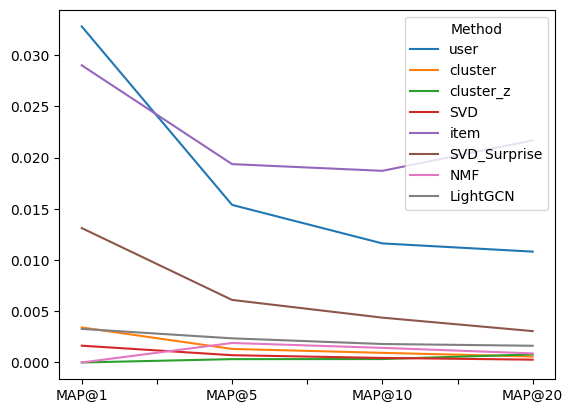

In [70]:
metrics_all.set_index('Method')[['MAP@1', 'MAP@5', 'MAP@10', 'MAP@20']].T.plot()

<Axes: >

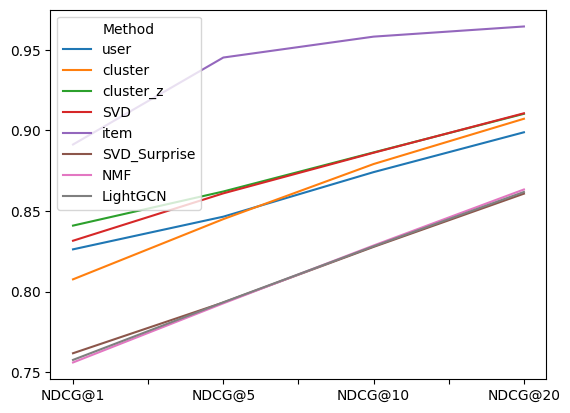

In [71]:
metrics_all.set_index('Method')[['NDCG@1', 'NDCG@5', 'NDCG@10', 'NDCG@20']].T.plot()